In [2]:
!pip -q install monai
!pip -q install timm
!pip -q install albumentations --upgrade
!pip -q install rasterio
!pip -q install colorama
!pip -q install wandb
!pip -q install segmentation-models-pytorch
!pip -q install opencv-python --upgrade

     |████████████████████████████████| 939 kB 646 kB/s 
     |████████████████████████████████| 431 kB 644 kB/s 
     |████████████████████████████████| 113 kB 656 kB/s 
     |████████████████████████████████| 48.3 MB 80.5 MB/s 
     |████████████████████████████████| 19.3 MB 405 kB/s 
     |████████████████████████████████| 1.8 MB 652 kB/s 
     |████████████████████████████████| 145 kB 59.3 MB/s 
     |████████████████████████████████| 181 kB 59.9 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 88 kB 773 kB/s 
     |████████████████████████████████| 58 kB 2.1 MB/s 
     |████████████████████████████████| 376 kB 2.9 MB/s 
     |████████████████████████████████| 60.9 MB 226 kB/s 


In [ ]:
#baseline reference: https://www.kaggle.com/code/awsaf49/uwmgi-unet-train-pytorch

In [3]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
from scipy.spatial.distance import directed_hausdorff
from monai.metrics.utils import get_mask_edges, get_surface_distance

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
#from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'Train pipeline ver 13.3'
    comment       = 'Unet+efb 320x384'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b4'
    postfix       = 'lr_cosine_aug4'
    train_bs      = 32
    valid_bs      = train_bs*2
    img_size      = [320, 384]
    epochs        = 40
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    aug           = 'train_aug4_b'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    folds         = [0]
    num_classes   = 3
    input_chnls   = 1
    val_freq      = 2
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#ref https://www.kaggle.com/code/andreyzotov/unet-train-ver-13-3 version 4

DATASET =    {'train':'resized-320x384.zip'}
OUTPUT_DIR = {'BSL':'/content/drive/My\ Drive/kaggle/gi_t_is/output/',
              'NORM':'/content/drive/My Drive/kaggle/gi_t_is/output/'}

INPUT_DIR ='/content/drive/My\ Drive/kaggle/gi_t_is/input/'


WORK_DIR='/content/'

DATASET_DIR = INPUT_DIR

EXPERIMENT= f'{CFG.model_name}_{CFG.backbone}_{CFG.img_size[0]}_{CFG.img_size[1]}_{CFG.input_chnls}_{CFG.postfix}'
EXPERIMENT_DIR = OUTPUT_DIR['BSL'] + EXPERIMENT+'/'
PATH_DIR = OUTPUT_DIR['NORM'] + EXPERIMENT+'/'


!mkdir {EXPERIMENT_DIR}

mkdir: cannot create directory ‘/content/drive/My Drive/kaggle/gi_t_is/output/Unet_efficientnet-b4_320_384_1_lr_cosine_aug4/’: File exists


In [8]:
def copy_dataset(ds_dict, ds_dir, work_dir):
  for record in ds_dict:
    print('copy', ds_dir+ds_dict[record], ' to', work_dir)
    !cp {ds_dir+ds_dict[record]} {work_dir}
    print('mkdir',work_dir+record)
    !mkdir {work_dir+record}
    print ('unzip -q ',work_dir+ds_dict[record],' -d ',work_dir+record)
    !unzip -q  {work_dir+ds_dict[record]} -d {work_dir+record}
    print ('rm ',work_dir+ds_dict[record])
    !rm {work_dir+ds_dict[record]}

In [9]:
copy_dataset(DATASET,DATASET_DIR,WORK_DIR)

copy /content/drive/My\ Drive/kaggle/gi_t_is/input/resized-320x384.zip  to /content/
mkdir /content/train
unzip -q  /content/resized-320x384.zip  -d  /content/train
rm  /content/resized-320x384.zip


In [10]:
!ls train/

np_mask  png_img  png_mask  train.csv


In [11]:
import wandb

try:
    api_key = 'cef6c5793d7af5dfbce82bfb21a7787c2123110c'
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,'\
          '\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB.'\
          '\nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [13]:
DS_WORK_DIR = WORK_DIR+'train/'

In [14]:
DS_WORK_DIR

'/content/train/'

In [15]:
df = pd.read_csv(DS_WORK_DIR+'train.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
df['resized_mask_path'] = df.resized_mask_path.str.replace('/png_mask','/np_mask').str.replace('.png','.npy')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks

df['resized_img_path'] = df.resized_img_path.str.replace("/kaggle/input/uwmgi-mask-dataset/",DS_WORK_DIR)
df['resized_mask_path'] = df.resized_mask_path.str.replace("/kaggle/input/uwmgi-mask-dataset/",DS_WORK_DIR)
df.head(1)

,id,case,day,slice,image_path,height,width,resized_mask_path,resized_img_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/content/train/np_mask/uw-madison-gi-tract-ima...,/content/train/png_img/uw-madison-gi-tract-ima...,"[, , ]",0,True


In [16]:
len(df)

38496

In [17]:
fault1 = 'case7_day0'
fault2 = 'case81_day30'
df = df[~df['id'].str.contains(fault1) & ~df['id'].str.contains(fault2)].reset_index(drop=True)
df.head(1)

,id,case,day,slice,image_path,height,width,resized_mask_path,resized_img_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/content/train/np_mask/uw-madison-gi-tract-ima...,/content/train/png_img/uw-madison-gi-tract-ima...,"[, , ]",0,True


In [18]:
len(df)

38208

In [19]:
def id2mask(id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, CFG.input_chnls]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)
    msk = msk.astype('float32')
    msk/=255.0
    return msk
    

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img[:,:,0], msk)
    plt.tight_layout()
    plt.show()

In [20]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False    3374
      True     4706
1.0   False    4112
      True     4896
2.0   False    2973
      True     3827
3.0   False    3407
      True     4689
4.0   False    2627
      True     3597
Name: id, dtype: int64

In [21]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['resized_img_path'].tolist()
        self.msk_paths  = df['resized_mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)
        #print('shape: ',img.shape)
        #assert img.shape[0],img.shape[1] == CFG.img_size
        
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            #print('mask shape: ',msk.shape)
            #assert msk.shape[0],msk.shape[1] == CFG.img_size
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            
            img = np.transpose(img, (2, 0, 1))
            #print("img shape: ", img.shape)
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

In [22]:
data_transforms = {
    "train_aug0": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
           A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "train_aug1": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "train_aug2": A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=0.4),
            A.Transpose(p=0.4),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            A.OneOf(
                [
                    A.RandomContrast(),
                    A.RandomGamma(),
                    A.RandomBrightness()
                ],
                p=0.3,
            ),
        ],
        p=0.5),
    
    "train_aug3": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.4),
        A.Transpose(p=0.4),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.OneOf([
                    A.RandomContrast(),
                    A.RandomGamma(),
                    A.RandomBrightness()
                ],p=0.3),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "train_aug4": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.4),
        A.Transpose(p=0.4),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.OneOf([
                    A.RandomContrast(),
                    A.RandomGamma(),
                    A.RandomBrightness()
                ],p=0.3),
        A.CoarseDropout(max_holes=1, max_height=CFG.img_size[0]//3, max_width=CFG.img_size[1]//3,
                         min_holes=1, fill_value=0, mask_fill_value=0, p=0.5),
    ], p=1.0),

    "train_aug4_b": A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.RandomRotate90(p=0.4),
        #A.Transpose(p=0.4),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.OneOf([
                    A.RandomContrast(),
                    A.RandomGamma(),
                    A.RandomBrightness()
                ],p=0.3),
        A.CoarseDropout(max_holes=1, max_height=CFG.img_size[0]//3, max_width=CFG.img_size[1]//3,
                         min_holes=1, fill_value=0, mask_fill_value=0, p=0.5),
    ], p=1.0),

}

In [23]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.head(32*5).query("empty==0")
        valid_df = valid_df.head(32*3).query("empty==0")
    train_dataset = BuildDataset(train_df, transforms=data_transforms[CFG.aug])
    valid_dataset = BuildDataset(valid_df, transforms=None)
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 20, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


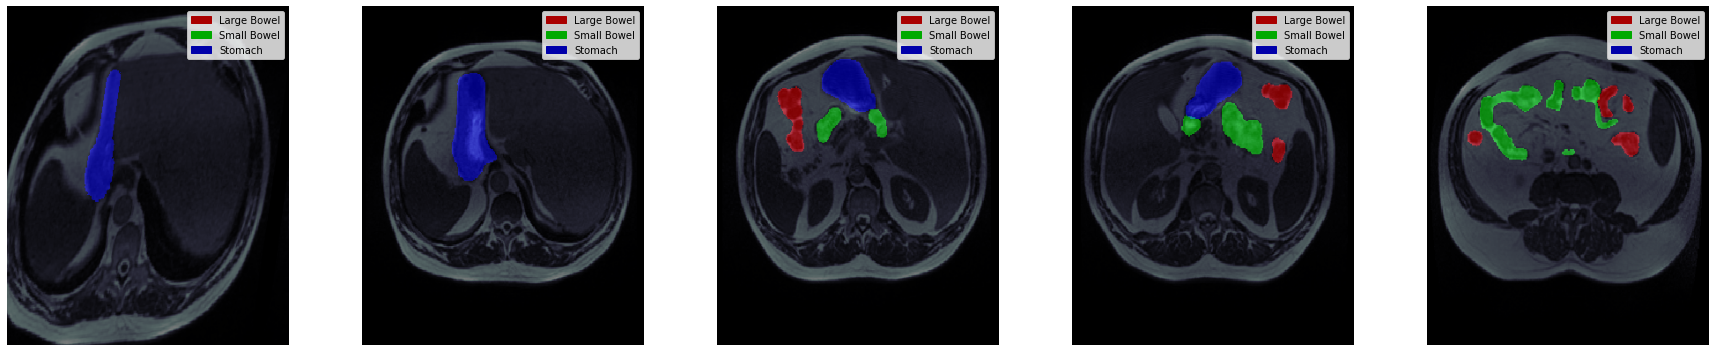

In [24]:
train_loader, valid_loader = prepare_loaders(fold=0, debug=True)
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()
plot_batch(imgs, msks, size=5)

In [25]:
del imgs,msks
import gc
gc.collect()

13155

In [26]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=CFG.input_chnls,    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [27]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return BCELoss(y_pred, y_true) + DiceLoss(y_pred, y_true) + TverskyLoss(y_pred,y_true)

#ref https://www.kaggle.com/code/yiheng/50-times-faster-way-get-hausdorff-with-monai
def hd_coef(y_pred,y_true,max_dist):
    
    if np.all(y_pred == y_true):
        return 0.0    
    
    dist = directed_hausdorff(np.argwhere(y_pred),np.argwhere(y_true))[0]
    
    if dist > max_dist:
        return 1.0
    
    return dist / max_dist

def hd_coef_monai(y_pred, y_true, max_dist):
    if np.all(y_pred == y_true):
        return 0.0
    (edges_pred, edges_true) = get_mask_edges(y_pred, y_true)
    surface_distance = get_surface_distance(edges_pred, edges_true, distance_metric="euclidean")
    if surface_distance.shape == (0,):
        return 0.0
    dist = surface_distance.max()
    if dist > max_dist:
        return 1.0
    return dist / max_dist

In [28]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, history, best_params):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    dataloader_len = len(dataloader)
   
    
    pbar = tqdm(enumerate(dataloader), total=dataloader_len, desc='Train ')
    pbar_len = len(pbar)
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        #print(f'loss={loss.item()}')
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        #print(f'r_loss={running_loss} ds_size={dataset_size}')
        train_loss = running_loss / dataset_size
        #print(f't_loss={train_loss}')
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{train_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
        
        if ((step+1) % (dataloader_len//CFG.val_freq) == 0) and (epoch > CFG.epochs//2):
            
            val_dice,val_jaccard,val_loss,val_hd_monai=do_valid(model,valid_loader,device)
            
            #if scheduler is not None:
            #    scheduler.step(val_dice)
            
            val_kaggle_metric = 0.4*val_dice+0.6*(1-val_hd_monai)
            history['Train Loss'].append(train_loss)
            history['Valid Loss'].append(val_loss)
            history['Valid Dice'].append(val_dice)
            history['Valid HD'].append(val_hd_monai)
            history['Valid Kaggle Meteic'].append(val_kaggle_metric)
            history['Valid Jaccard'].append(val_jaccard)
    
            # Log the metrics
            wandb.log({"Train Loss": train_loss, 
               "Valid Loss": val_loss,
               "Valid Dice": val_dice,
               "Valid HD": val_hd_monai,
               "Valid Kaggle Metric": val_kaggle_metric,
               "Valid Jaccard": val_jaccard,
               "LR":scheduler.optimizer.param_groups[0]['lr']})
    
            print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f} | '\
                  f'1 - Valid HD monai: {1 - val_hd_monai:0.4f} | '\
                  f'Valid kaggle metric: {val_kaggle_metric: 0.4f}')
           
    
            
            if val_dice > best_params['best_dice']:
                print(f"{c_}Valid Score Improved ({best_params['best_dice']:0.4f} ---> {val_dice:0.4f})")
               
                best_params['best_dice'] = val_dice
                best_params['best_jaccard'] = val_jaccard
                best_params['best_epoch'] = epoch
                
                run.summary["Best Dice"]    = val_dice
                run.summary["Best Jaccard"] = val_jaccard
                run.summary["Best Epoch"]   = epoch
                
                PATH = PATH_DIR+f"best_valid-{fold:02d}_{val_dice:0.4f}.bin"
                torch.save(model.state_dict(), PATH)
                # Save a model file from the current directory
                wandb.save(PATH)
                print(f"Model Saved{sr_}")
                
            
            
    torch.cuda.empty_cache()
    gc.collect()
    
    return

In [29]:
@torch.no_grad()
def do_valid(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    dataloader_len = len(dataloader)
    
    pbar = tqdm(enumerate(dataloader), total=dataloader_len, desc='Valid ')
    #max_dist0 = CFG.img_size[0]**2+CFG.img_size[1]**2 
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        val_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        
        #y_true_np = masks.to(torch.float32).detach().cpu().numpy()
        #y_pred_np = (y_pred>0.5).to(torch.float32).detach().cpu().numpy()
        
        #max_dist = np.sqrt(max_dist0+batch_size**2)
        #val_hd = 0
        val_hd_monai = 0
        #print("calc val_hd_monai: start")
        #for i in range(3):
            #val_hd += (hd_coef(y_pred_np[:,i,:,:],y_true_np[:,i,:,:], max_dist))
            #val_hd_monai += hd_coef_monai(y_pred_np[:,i,:,:],y_true_np[:,i,:,:],max_dist)
        #val_hd /= 3.0
        #val_hd_monai /= 3.0
        #print("calc val_hd_monai: stop")
        #del y_pred_np,y_true_np
        #gc.collect()
        
        val_scores.append([val_dice, val_jaccard,val_loss,val_hd_monai])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{val_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    model.train()
            
    return val_scores

In [ ]:
def save_last_state(model,optimizer,scheduler,epoch,history,best_params):
  if False:
    state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'history': history,
    'best_params': best_params,}
    filepath = PATH_DIR+'last_model_state.pt'
    torch.save(state, filepath)
  pass

In [30]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
   
    best_params = {'best_dice':-np.inf,
                   'best_jaccard': -np.inf,
                   'best_epoch': -1}
    
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_one_epoch(model, optimizer, scheduler, dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch,history=history,best_params=best_params)
        save_last_state(model,optimizer,scheduler,epoch,history,best_params)            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Dice Score: {:.4f}".format(best_params['best_dice']))

    
    return  history

In [31]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='max',
                                                   factor=0.333,
                                                   patience=5,
                                                   threshold=0.0001,
                                                   min_lr=0,
                                                   verbose = True)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [32]:
for fold in CFG.folds:
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='uw-maddison-gi-tract', 
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous=anonymous,
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     group=CFG.comment,
                    )
    train_loader, valid_loader = prepare_loaders(fold=fold, debug=CFG.debug)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    history   = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

wandb: Currently logged in as: diwert. Use `wandb login --relogin` to force relogin


###############
### Fold: 0
###############


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

cuda: Tesla T4

Epoch 1/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 2/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 3/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 4/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 5/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 6/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 7/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 8/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 9/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 10/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 11/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 12/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 13/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 14/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 15/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 16/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 17/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 18/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 19/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 20/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]



Epoch 21/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9016 | Valid Jaccard: 0.8733 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9606
Valid Score Improved (-inf ---> 0.9016)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9002 | Valid Jaccard: 0.8717 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9601


Epoch 22/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9026 | Valid Jaccard: 0.8753 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9611
Valid Score Improved (0.9016 ---> 0.9026)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9004 | Valid Jaccard: 0.8729 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9602


Epoch 23/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9088 | Valid Jaccard: 0.8812 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9635
Valid Score Improved (0.9026 ---> 0.9088)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9070 | Valid Jaccard: 0.8792 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9628


Epoch 24/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9055 | Valid Jaccard: 0.8776 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9622


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.8973 | Valid Jaccard: 0.8709 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9589


Epoch 25/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9076 | Valid Jaccard: 0.8801 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9630


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9096 | Valid Jaccard: 0.8820 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9638
Valid Score Improved (0.9088 ---> 0.9096)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 26/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9091 | Valid Jaccard: 0.8810 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9637


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9050 | Valid Jaccard: 0.8777 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9620


Epoch 27/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9080 | Valid Jaccard: 0.8805 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9632


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9054 | Valid Jaccard: 0.8781 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9622


Epoch 28/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9072 | Valid Jaccard: 0.8803 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9629


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9083 | Valid Jaccard: 0.8807 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9633


Epoch 29/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9077 | Valid Jaccard: 0.8808 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9631


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9051 | Valid Jaccard: 0.8781 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9620


Epoch 30/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9070 | Valid Jaccard: 0.8797 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9628


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9102 | Valid Jaccard: 0.8829 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9641
Valid Score Improved (0.9096 ---> 0.9102)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 31/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9110 | Valid Jaccard: 0.8838 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9644
Valid Score Improved (0.9102 ---> 0.9110)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9083 | Valid Jaccard: 0.8816 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9633


Epoch 32/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9080 | Valid Jaccard: 0.8802 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9632


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9085 | Valid Jaccard: 0.8808 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9634


Epoch 33/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9112 | Valid Jaccard: 0.8837 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9645
Valid Score Improved (0.9110 ---> 0.9112)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9100 | Valid Jaccard: 0.8827 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9640


Epoch 34/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9102 | Valid Jaccard: 0.8829 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9641


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9100 | Valid Jaccard: 0.8823 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9640


Epoch 35/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9111 | Valid Jaccard: 0.8836 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9644


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9116 | Valid Jaccard: 0.8842 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9646
Valid Score Improved (0.9112 ---> 0.9116)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 36/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9118 | Valid Jaccard: 0.8845 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9647
Valid Score Improved (0.9116 ---> 0.9118)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9114 | Valid Jaccard: 0.8841 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9646


Epoch 37/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9119 | Valid Jaccard: 0.8847 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9648
Valid Score Improved (0.9118 ---> 0.9119)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9119 | Valid Jaccard: 0.8847 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9648
Valid Score Improved (0.9119 ---> 0.9119)


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Model Saved


Epoch 38/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9106 | Valid Jaccard: 0.8835 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9643


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9107 | Valid Jaccard: 0.8835 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9643


Epoch 39/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9111 | Valid Jaccard: 0.8839 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9644


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9110 | Valid Jaccard: 0.8838 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9644


Epoch 40/40

Train :   0%|          | 0/942 [00:00<?, ?it/s]

Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9108 | Valid Jaccard: 0.8836 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9643


Valid :   0%|          | 0/127 [00:00<?, ?it/s]

Valid Dice: 0.9112 | Valid Jaccard: 0.8840 | 1 - Valid HD monai: 1.0000 | Valid kaggle metric:  0.9645


Training complete in 17h 22m 16s
Best Dice Score: 0.9119


LR,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Train Loss,████▇▆▆▆▆▆▅▅▅▄▄▄▃▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁
Valid Dice,▃▂▄▂▇▆▅▁▆▇▇▅▆▅▆▆▆▅▆▇█▆▆▆█▇▇▇██████▇▇██▇█
Valid HD,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Jaccard,▂▁▃▂▆▅▄▁▆▇▆▄▆▅▆▆▆▅▅▇█▆▆▆▇▇▇▇▇█████▇▇██▇█
Valid Kaggle Metric,▃▂▄▂▇▆▅▁▆▇▇▅▆▅▆▆▆▅▆▇█▆▆▆█▇▇▇██████▇▇██▇█
Valid Loss,▃▆▅▆▃▄▄█▃▃▁▅▃▅▅▃▄▆▃▃▃▄▃▂▂▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃
Best Dice,0.91192
Best Epoch,37
Best Jaccard,0.88467
LR,0.0
